# WGAN

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train - 127.5) / 127.5
print(x_train.shape, x_train.min(), x_train.max())

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) -1.0 1.0


In [2]:
def make_critic():
    dx = tf.keras.Input(shape=[28, 28, 1])
    dh = tf.keras.layers.Conv2D(64, 5, 2, padding="same")(dx)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Conv2D(128, 5, 2, padding="same")(dh)
    dh = tf.keras.layers.LeakyReLU(alpha=0.2)(dh)
    dh = tf.keras.layers.Flatten()(dh)
    dy = tf.keras.layers.Dense(1)(dh)
    return tf.keras.Model(dx, dy)

def make_generator():
    gx = tf.keras.Input(shape=[100])
    gh = tf.keras.layers.Dense(7 * 7 * 128)(gx)
    gh = tf.keras.layers.Reshape([7, 7, 128])(gh)
    gh = tf.keras.layers.Conv2DTranspose(128, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gh = tf.keras.layers.Conv2DTranspose(64, 5, 2, padding="same")(gh)
    gh = tf.keras.layers.BatchNormalization()(gh)
    gh = tf.keras.layers.Activation('swish')(gh)
    gy = tf.keras.layers.Conv2DTranspose(1, 7, padding="same", activation="tanh")(gh)
    return tf.keras.Model(gx, gy)


In [3]:
class WGAN(tf.keras.Model):
    def __init__(self, g, c):
        super(WGAN, self).__init__()
        self.compile()

        self.generator = g
        self.critic = c

        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        self.c_loss_metrics = tf.keras.metrics.Mean()
        self.g_loss_metrics = tf.keras.metrics.Mean()

    def critic_loss(self, y_real, y_fake):
        y_true = tf.concat([-tf.ones_like(y_real), tf.ones_like(y_fake)], axis=0)
        y_pred = tf.concat([y_real, y_fake], axis=0)
        return -1 * tf.reduce_mean(y_true * y_pred)
    
    def gen_loss(self, y_fake):
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_fake), y_fake)
        return -1 * tf.reduce_mean(-tf.ones_like(y_fake) * y_fake)

    def update_metrics(self, g_loss, c_loss):
        self.c_loss_metrics.update_state(c_loss)
        self.g_loss_metrics.update_state(g_loss)

    def train_step(self, real):
        noise = tf.random.normal([tf.shape(real)[0], 100])
        with tf.GradientTape() as g_tape, tf.GradientTape() as c_tape:
            fake = self.generator(noise, training=True)
            y_real = self.critic(real, training=True)
            y_fake = self.critic(fake, training=True)

            g_loss = self.gen_loss(y_fake)
            c_loss = self.critic_loss(y_real, y_fake)

            g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)    
            c_grad = c_tape.gradient(c_loss, self.critic.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        self.c_optimizer.apply_gradients(zip(c_grad, self.critic.trainable_variables))

        self.update_metrics(g_loss, c_loss)
        return {
            "c_loss": self.c_loss_metrics.result(),
            "g_loss": self.g_loss_metrics.result(),
        }


In [4]:
critic = make_critic()
generator = make_generator()
gen = WGAN(generator, critic)

In [5]:
import matplotlib.pyplot as plt
import numpy as np

class Monitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_rnd = np.random.randn(5 * 100).reshape(5, 100)
        generated = self.model.generator(x_rnd)
        for i in range(5):
            plt.subplot(1, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated[i].numpy().reshape(28, 28), cmap='gray_r')
        plt.show()

Epoch 1/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1147 - g_loss: -3.8991

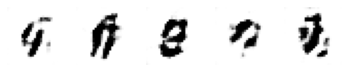

469/469 [==============================] - 24s 25ms/step - c_loss: -0.1145 - g_loss: -3.8974
Epoch 2/20
467/469 [============================>.] - ETA: 0s - c_loss: -0.0486 - g_loss: -1.8960

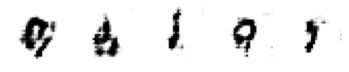

469/469 [==============================] - 11s 22ms/step - c_loss: -0.0486 - g_loss: -1.9061
Epoch 3/20
467/469 [============================>.] - ETA: 0s - c_loss: -0.0750 - g_loss: -6.9122

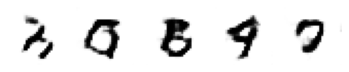

469/469 [==============================] - 11s 23ms/step - c_loss: -0.0752 - g_loss: -6.9256
Epoch 4/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.1544 - g_loss: -15.5377

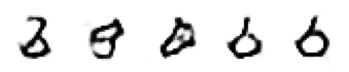

469/469 [==============================] - 11s 23ms/step - c_loss: -0.1545 - g_loss: -15.5468
Epoch 5/20
469/469 [==============================] - ETA: 0s - c_loss: -0.5502 - g_loss: -52.0542

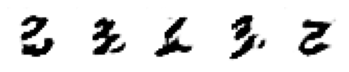

469/469 [==============================] - 11s 23ms/step - c_loss: -0.5511 - g_loss: -52.1023
Epoch 6/20
467/469 [============================>.] - ETA: 0s - c_loss: -1.3320 - g_loss: -47.5454

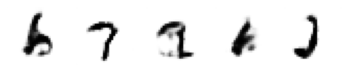

469/469 [==============================] - 11s 23ms/step - c_loss: -1.3252 - g_loss: -47.7673
Epoch 7/20
469/469 [==============================] - ETA: 0s - c_loss: -0.7173 - g_loss: -103.7781

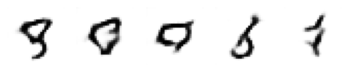

469/469 [==============================] - 11s 23ms/step - c_loss: -0.7172 - g_loss: -103.7763
Epoch 8/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.3792 - g_loss: -127.8999

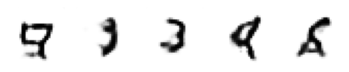

469/469 [==============================] - 11s 22ms/step - c_loss: -0.3794 - g_loss: -127.8736
Epoch 9/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.4652 - g_loss: -126.5019

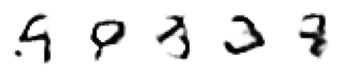

469/469 [==============================] - 11s 23ms/step - c_loss: -0.4653 - g_loss: -126.5087
Epoch 10/20
467/469 [============================>.] - ETA: 0s - c_loss: -0.3371 - g_loss: -135.3547

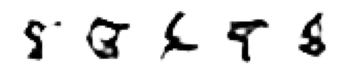

469/469 [==============================] - 11s 23ms/step - c_loss: -0.3375 - g_loss: -135.3546
Epoch 11/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.4224 - g_loss: -133.9550

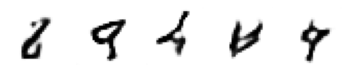

469/469 [==============================] - 11s 23ms/step - c_loss: -0.4224 - g_loss: -133.9567
Epoch 12/20
467/469 [============================>.] - ETA: 0s - c_loss: -0.4318 - g_loss: -137.8860

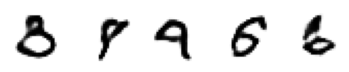

469/469 [==============================] - 11s 23ms/step - c_loss: -0.4322 - g_loss: -137.8810
Epoch 13/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.5485 - g_loss: -145.3112

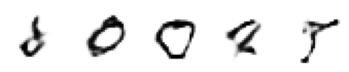

469/469 [==============================] - 11s 23ms/step - c_loss: -0.5486 - g_loss: -145.2892
Epoch 14/20
469/469 [==============================] - ETA: 0s - c_loss: -0.8073 - g_loss: -144.0172

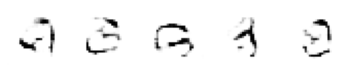

469/469 [==============================] - 11s 23ms/step - c_loss: -0.8087 - g_loss: -144.0568
Epoch 15/20
467/469 [============================>.] - ETA: 0s - c_loss: -1.1005 - g_loss: -142.8886

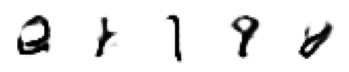

469/469 [==============================] - 11s 23ms/step - c_loss: -1.0974 - g_loss: -143.0372
Epoch 16/20
469/469 [==============================] - ETA: 0s - c_loss: -0.8540 - g_loss: -184.4164

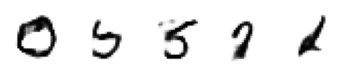

469/469 [==============================] - 11s 23ms/step - c_loss: -0.8541 - g_loss: -184.4289
Epoch 17/20
469/469 [==============================] - ETA: 0s - c_loss: -0.9802 - g_loss: -186.4889

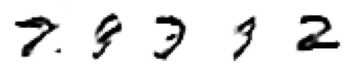

469/469 [==============================] - 11s 23ms/step - c_loss: -0.9802 - g_loss: -186.4873
Epoch 18/20
467/469 [============================>.] - ETA: 0s - c_loss: -1.2147 - g_loss: -179.6188

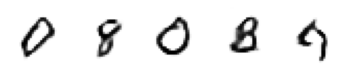

469/469 [==============================] - 11s 23ms/step - c_loss: -1.2143 - g_loss: -179.6409
Epoch 19/20
467/469 [============================>.] - ETA: 0s - c_loss: -1.4480 - g_loss: -191.6995

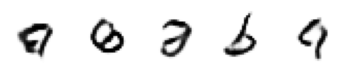

469/469 [==============================] - 11s 23ms/step - c_loss: -1.4471 - g_loss: -191.7260
Epoch 20/20
468/469 [============================>.] - ETA: 0s - c_loss: -1.4021 - g_loss: -187.8463

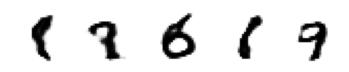

469/469 [==============================] - 11s 23ms/step - c_loss: -1.4021 - g_loss: -187.8966


In [6]:
gen.fit(x_train.reshape(-1, 28, 28, 1), epochs=20, batch_size=128, callbacks=[Monitor()])

(25, 100)


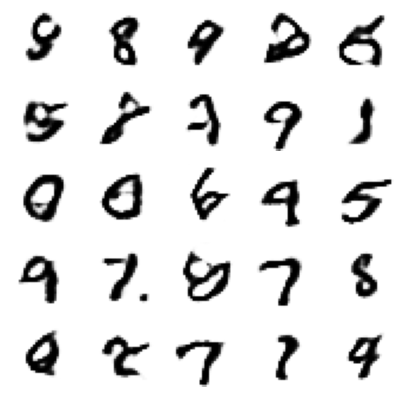

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x_test = np.random.randn(25 * 100).reshape(25, 100)
print(x_test.shape)
plt.figure(figsize=(7, 7))
generated = generator.predict(x_test)
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(generated[i].reshape(28, 28), cmap="gray_r")
plt.show()

In [ ]:
critic.get_weights()

# WGAN GP

In [ ]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, g, c):
        super(WGAN_GP, self).__init__()
        self.compile()

        self.generator = g
        self.critic = c

        self.c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        self.c_loss_metrics = tf.keras.metrics.Mean()
        self.g_loss_metrics = tf.keras.metrics.Mean()

    def critic_loss(self, y_real, y_fake):
        y_true = tf.concat([-tf.ones_like(y_real), tf.ones_like(y_fake)], axis=0)
        y_pred = tf.concat([y_real, y_fake], axis=0)
        return -1 * tf.reduce_mean(y_true * y_pred)
    
    def gen_loss(self, y_fake):
        g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(y_fake), y_fake)
        return -1 * tf.reduce_mean(-tf.ones_like(y_fake) * y_fake)

    def gp(self, real, fake):
        e = tf.random.uniform([tf.shape(real)[0], 1, 1, 1], 0.0, 1.0)
        x_hat = e * real + (1 - e) * fake
        with tf.GradientTape() as t:
            t.watch(x_hat)
            y_pred = self.critic(x_hat, training=True)
            grads = t.gradient(y_pred, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(grads ** 2, axis=[1, 2]))
        gp = tf.reduce_mean((ddx - 1) ** 2)
        return gp

    def update_metrics(self, g_loss, c_loss):
        self.c_loss_metrics.update_state(c_loss)
        self.g_loss_metrics.update_state(g_loss)

    def train_step(self, real):
        noise = tf.random.normal([tf.shape(real)[0], 100])
        with tf.GradientTape() as g_tape, tf.GradientTape() as c_tape:
            fake = self.generator(noise, training=True)
            y_real = self.critic(real, training=True)
            y_fake = self.critic(fake, training=True)

            g_loss = self.gen_loss(y_fake)
            c_loss = self.critic_loss(y_real, y_fake) + self.gp(real, fake) * 10

            g_grad = g_tape.gradient(g_loss, self.generator.trainable_variables)    
            c_grad = c_tape.gradient(c_loss, self.critic.trainable_variables)

        self.g_optimizer.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        self.c_optimizer.apply_gradients(zip(c_grad, self.critic.trainable_variables))

        self.update_metrics(g_loss, c_loss)
        return {
            "c_loss": self.c_loss_metrics.result(),
            "g_loss": self.g_loss_metrics.result(),
        }


In [ ]:
critic = make_critic()
generator = make_generator()
gen = WGAN_GP(generator, critic)

Epoch 1/20
469/469 [==============================] - ETA: 0s - c_loss: 1.3612 - g_loss: -11.7081

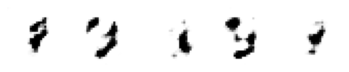

469/469 [==============================] - 28s 29ms/step - c_loss: 1.3591 - g_loss: -11.7092
Epoch 2/20
469/469 [==============================] - ETA: 0s - c_loss: -0.0423 - g_loss: -9.1929

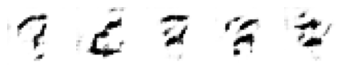

469/469 [==============================] - 14s 29ms/step - c_loss: -0.0423 - g_loss: -9.1916
Epoch 3/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1403 - g_loss: -8.8200

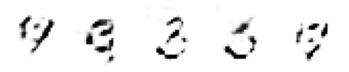

469/469 [==============================] - 15s 32ms/step - c_loss: -0.1403 - g_loss: -8.8202
Epoch 4/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1528 - g_loss: -7.9596

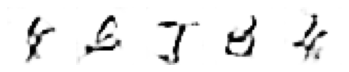

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1527 - g_loss: -7.9604
Epoch 5/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1380 - g_loss: -7.5944

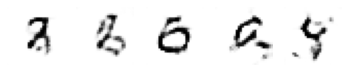

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1380 - g_loss: -7.5944
Epoch 6/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.1360 - g_loss: -7.8921

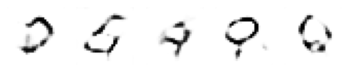

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1360 - g_loss: -7.8918
Epoch 7/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1567 - g_loss: -7.5077

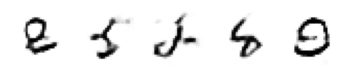

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1567 - g_loss: -7.5076
Epoch 8/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1482 - g_loss: -7.1452

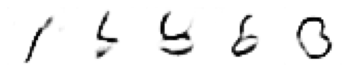

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1482 - g_loss: -7.1448
Epoch 9/20
468/469 [============================>.] - ETA: 0s - c_loss: -0.1692 - g_loss: -6.0268

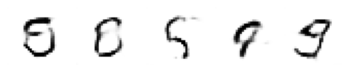

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1691 - g_loss: -6.0281
Epoch 10/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1710 - g_loss: -5.9440

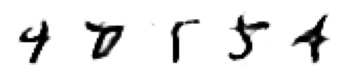

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1710 - g_loss: -5.9442
Epoch 11/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1754 - g_loss: -5.8443

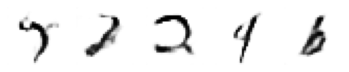

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1754 - g_loss: -5.8436
Epoch 12/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1964 - g_loss: -5.3901

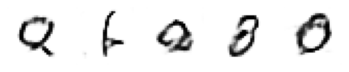

469/469 [==============================] - 14s 29ms/step - c_loss: -0.1963 - g_loss: -5.3903
Epoch 13/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1696 - g_loss: -5.1958

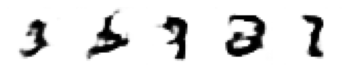

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1696 - g_loss: -5.1942
Epoch 14/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1953 - g_loss: -4.7907

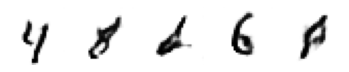

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1953 - g_loss: -4.7905
Epoch 15/20
469/469 [==============================] - ETA: 0s - c_loss: -0.2070 - g_loss: -4.5718

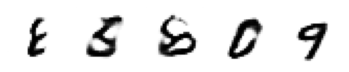

469/469 [==============================] - 14s 30ms/step - c_loss: -0.2070 - g_loss: -4.5719
Epoch 16/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1998 - g_loss: -4.2992

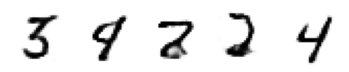

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1998 - g_loss: -4.2995
Epoch 17/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1994 - g_loss: -4.6660

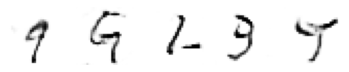

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1993 - g_loss: -4.6656
Epoch 18/20
469/469 [==============================] - ETA: 0s - c_loss: -0.2004 - g_loss: -4.7276

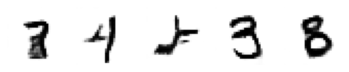

469/469 [==============================] - 14s 30ms/step - c_loss: -0.2004 - g_loss: -4.7269
Epoch 19/20
469/469 [==============================] - ETA: 0s - c_loss: -0.1850 - g_loss: -3.7646

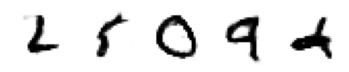

469/469 [==============================] - 14s 30ms/step - c_loss: -0.1851 - g_loss: -3.7649
Epoch 20/20
469/469 [==============================] - ETA: 0s - c_loss: -0.2011 - g_loss: -3.6416

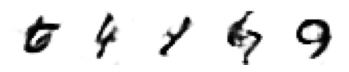

469/469 [==============================] - 14s 30ms/step - c_loss: -0.2011 - g_loss: -3.6417


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class Monitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        x_rnd = np.random.randn(5 * 100).reshape(5, 100)
        generated = self.model.generator(x_rnd)
        for i in range(5):
            plt.subplot(1, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated[i].numpy().reshape(28, 28), cmap='gray_r')
        plt.show()

gen.fit(x_train.reshape(-1, 28, 28, 1), epochs=20, batch_size=128, callbacks=[Monitor()])

# CNN More + CIFAR-10

In [8]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train = x_train / 255.
x_test = x_test / 255.

170508288/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


## VGG16


![image](https://adeshpande3.github.io/assets/VGGNet.png)


In [10]:
def vgg_block(filters, net):
    net = tf.keras.layers.Conv2D(filters, 3, 1, padding='same')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters, 3, 1, padding='same')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    # net = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='same')(net)
    net = tf.keras.layers.Conv2D(filters, 3, 2, padding="same")(net)
    return net

In [16]:
X = tf.keras.layers.Input(shape=(32, 32, 3))

net = vgg_block(64, X)
net = vgg_block(128, net)
net = vgg_block(256, net)
net = vgg_block(512, net)
net = vgg_block(512, net)

net = tf.keras.layers.Flatten()(net)
# net = tf.keras.layers.Dense(4096)(net)
# net = tf.keras.layers.BatchNormalization()(net)
# net = tf.keras.layers.Activation('swish')(net)
# net = tf.keras.layers.Dense(4096)(net)
# net = tf.keras.layers.BatchNormalization()(net)
# net = tf.keras.layers.Activation('swish')(net)
net = tf.keras.layers.Dense(1000)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)

Y = tf.keras.layers.Dense(10, activation="softmax")(net)

model = tf.keras.models.Model(X, Y)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=['accuracy'] 
)

In [17]:
model.fit(x_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 21s 61ms/step - loss: 1.6216 - accuracy: 0.3970 - val_loss: 4.0169 - val_accuracy: 0.1569
Epoch 2/20
313/313 [==============================] - 19s 59ms/step - loss: 1.1593 - accuracy: 0.5786 - val_loss: 1.7612 - val_accuracy: 0.4856
Epoch 3/20
313/313 [==============================] - 18s 58ms/step - loss: 0.9319 - accuracy: 0.6680 - val_loss: 1.0463 - val_accuracy: 0.6785
Epoch 4/20
313/313 [==============================] - 18s 58ms/step - loss: 0.7678 - accuracy: 0.7293 - val_loss: 1.3029 - val_accuracy: 0.6296
Epoch 5/20
313/313 [==============================] - 18s 58ms/step - loss: 0.6535 - accuracy: 0.7730 - val_loss: 0.8189 - val_accuracy: 0.7461
Epoch 6/20
313/313 [==============================] - 18s 58ms/step - loss: 0.5715 - accuracy: 0.8023 - val_loss: 0.9714 - val_accuracy: 0.7209
Epoch 7/20
313/313 [==============================] - 18s 58ms/step - loss: 0.4988 - accuracy: 0.8274 - val_loss: 1.0560 - val_accuracy:

## augmentation + early stopping

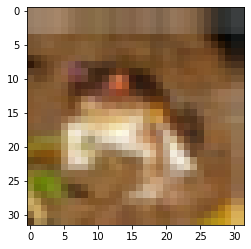

In [18]:
import matplotlib.pyplot as plt
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1, 
    rotation_range=0.1, 
    horizontal_flip=True
)
train_ds = datagen.flow(x_train[0].reshape(-1, 32, 32, 3), batch_size=1)
x = next(iter(train_ds))
plt.imshow(x[0])

In [19]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1, 
    rotation_range=0.1, 
    horizontal_flip=True
)
train_ds = datagen.flow(x_train[:40000], y_train[:40000], batch_size=128)
valid_ds = tf.data.Dataset.from_tensor_slices((x_train[40000:], y_train[40000:]))
valid_ds = valid_ds.batch(128)

In [23]:
es = tf.keras.callbacks.EarlyStopping(patience=5)
model.fit(train_ds, epochs=10000, validation_data=valid_ds, callbacks=[es])

Epoch 1/10000
313/313 [==============================] - 28s 90ms/step - loss: 0.4252 - accuracy: 0.8559 - val_loss: 0.4692 - val_accuracy: 0.8473
Epoch 2/10000
313/313 [==============================] - 24s 77ms/step - loss: 0.3875 - accuracy: 0.8670 - val_loss: 0.4998 - val_accuracy: 0.8383
Epoch 3/10000
313/313 [==============================] - 24s 77ms/step - loss: 0.3600 - accuracy: 0.8780 - val_loss: 0.4403 - val_accuracy: 0.8571
Epoch 4/10000
313/313 [==============================] - 25s 79ms/step - loss: 0.3405 - accuracy: 0.8845 - val_loss: 0.4843 - val_accuracy: 0.8457
Epoch 5/10000
313/313 [==============================] - 24s 77ms/step - loss: 0.3232 - accuracy: 0.8873 - val_loss: 0.4657 - val_accuracy: 0.8509
Epoch 6/10000
313/313 [==============================] - 24s 78ms/step - loss: 0.3001 - accuracy: 0.8975 - val_loss: 0.4368 - val_accuracy: 0.8610
Epoch 7/10000
313/313 [==============================] - 24s 77ms/step - loss: 0.2884 - accuracy: 0.9005 - val_loss: 0

In [24]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.4883 - accuracy: 0.8560


[0.4882522523403168, 0.8560000061988831]

## ResNet

![image](https://cdn-images-1.medium.com/max/1314/1*S3TlG0XpQZSIpoDIUCQ0RQ.jpeg)

![image](https://cdn-images-1.medium.com/max/1600/1*aq0q7gCvuNUqnMHh4cpnIw.png)

![image](https://1.bp.blogspot.com/-J5pbMKnnmZ0/V9t_aeGiEnI/AAAAAAAAB6c/f8-B42TxWAwasaXYpzKyOzUT2DqgpfZ9QCEw/s1600/%25E1%2584%2591%25E1%2585%25A1%25E1%2584%258B%25E1%2585%25B5%25E1%2586%25AF%2B2016.%2B9.%2B16.%2B%25E1%2584%258B%25E1%2585%25A9%25E1%2584%258C%25E1%2585%25A5%25E1%2586%25AB%2B9%2B10%2B32.jpeg)


In [25]:
def residual_block(filters, x):
    net = tf.keras.layers.BatchNormalization()(x)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters, 3, padding='same')(net)
    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters, 3, padding='same')(net)

    if filters != x.shape[-1]:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Conv2D(filters, 1, 1, padding='same')(x)

    net = tf.keras.layers.Add()([x, net])

    return net

def residual_block_2(filters, x):
    net = tf.keras.layers.BatchNormalization()(x)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters // 4, 1, padding="same")(net)

    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters // 4, 3, padding="same")(net)

    net = tf.keras.layers.BatchNormalization()(net)
    net = tf.keras.layers.Activation('swish')(net)
    net = tf.keras.layers.Conv2D(filters, 1, padding="same")(net)

    if filters != x.shape[-1]:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Conv2D(filters, 1, padding='same')(x)

    net = tf.keras.layers.Add()([x, net])
    return net


In [33]:
X = tf.keras.layers.Input(shape=(32, 32, 3))

net = tf.keras.layers.Conv2D(64, 5, padding="same")(X)
# net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)
net = tf.keras.layers.Conv2D(64, 3, 2, padding="same")(net)

for i in range(3):
    net = residual_block_2(128, net)
# net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)
net = tf.keras.layers.Conv2D(128, 3, 2, padding="same")(net)

for i in range(4):
    net = residual_block_2(256, net)
# net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)
net = tf.keras.layers.Conv2D(256, 3, 2, padding="same")(net)

for i in range(6):
    net = residual_block_2(512, net)
# net = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(net)
net = tf.keras.layers.Conv2D(512, 3, 2, padding="same")(net)

for i in range(3):
    net = residual_block_2(1024, net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)
# net = tf.keras.layers.GlobalAveragePooling2D()(net)
net = tf.keras.layers.Conv2D(1024, 2)(net)
net = tf.keras.layers.Flatten()(net)

net = tf.keras.layers.Dense(1000)(net)
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Activation('swish')(net)

Y = tf.keras.layers.Dense(10, activation='softmax')(net)

model = tf.keras.models.Model(X, Y)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [34]:
# basic trainning with early stopping 
es = tf.keras.callbacks.EarlyStopping(patience=5)
model.fit(x_train, y_train, epochs=10000, batch_size=128, validation_split=0.2, callbacks=[es])

Epoch 1/10000
313/313 [==============================] - 30s 76ms/step - loss: 1.6565 - accuracy: 0.3984 - val_loss: 2.2430 - val_accuracy: 0.3127
Epoch 2/10000
313/313 [==============================] - 23s 74ms/step - loss: 1.1642 - accuracy: 0.5806 - val_loss: 1.3645 - val_accuracy: 0.5797
Epoch 3/10000
313/313 [==============================] - 22s 72ms/step - loss: 0.8762 - accuracy: 0.6896 - val_loss: 1.2839 - val_accuracy: 0.6037
Epoch 4/10000
313/313 [==============================] - 23s 72ms/step - loss: 0.7098 - accuracy: 0.7484 - val_loss: 0.8891 - val_accuracy: 0.7068
Epoch 5/10000
313/313 [==============================] - 22s 72ms/step - loss: 0.6127 - accuracy: 0.7876 - val_loss: 0.7839 - val_accuracy: 0.7414
Epoch 6/10000
313/313 [==============================] - 22s 72ms/step - loss: 0.4908 - accuracy: 0.8283 - val_loss: 0.9881 - val_accuracy: 0.7082
Epoch 7/10000
313/313 [==============================] - 23s 74ms/step - loss: 0.3971 - accuracy: 0.8615 - val_loss: 0

In [35]:
# augmentation trainning with early stopping 
es = tf.keras.callbacks.EarlyStopping(patience=5)
model.fit(train_ds, epochs=10000, validation_data=valid_ds, callbacks=[es])

Epoch 1/10000
313/313 [==============================] - 32s 90ms/step - loss: 0.6065 - accuracy: 0.7916 - val_loss: 0.7168 - val_accuracy: 0.7764
Epoch 2/10000
313/313 [==============================] - 27s 87ms/step - loss: 0.5932 - accuracy: 0.7980 - val_loss: 0.7226 - val_accuracy: 0.7668
Epoch 3/10000
313/313 [==============================] - 27s 87ms/step - loss: 0.5098 - accuracy: 0.8241 - val_loss: 0.7727 - val_accuracy: 0.7476
Epoch 4/10000
313/313 [==============================] - 27s 87ms/step - loss: 0.4631 - accuracy: 0.8373 - val_loss: 0.5310 - val_accuracy: 0.8219
Epoch 5/10000
313/313 [==============================] - 28s 89ms/step - loss: 0.4311 - accuracy: 0.8514 - val_loss: 0.5955 - val_accuracy: 0.8027
Epoch 6/10000
313/313 [==============================] - 27s 87ms/step - loss: 0.4124 - accuracy: 0.8587 - val_loss: 0.5016 - val_accuracy: 0.8320
Epoch 7/10000
313/313 [==============================] - 27s 87ms/step - loss: 0.3876 - accuracy: 0.8667 - val_loss: 0

In [36]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 5s 14ms/step - loss: 0.5030 - accuracy: 0.8386


[0.503000020980835, 0.8385999798774719]

# RNN

In [2]:
import tensorflow as tf 

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

x_train = x_train / 255.
x_test = x_test / 255.

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(60000, 28, 28) (60000,)
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [9]:
X = tf.keras.layers.Input(shape=(28, 28))
net = tf.keras.layers.LSTM(32)(X)
Y = tf.keras.layers.Dense(10, activation='softmax')(net)

model = tf.keras.models.Model(X, Y)
model.compile(loss="sparse_categorical_crossentropy", metrics='accuracy')

In [10]:
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
375/375 [==============================] - 3s 6ms/step - loss: 1.2614 - accuracy: 0.5904 - val_loss: 0.7110 - val_accuracy: 0.7746
Epoch 2/10
375/375 [==============================] - 2s 5ms/step - loss: 0.5494 - accuracy: 0.8311 - val_loss: 0.4114 - val_accuracy: 0.8782
Epoch 3/10
375/375 [==============================] - 2s 5ms/step - loss: 0.3440 - accuracy: 0.8977 - val_loss: 0.2970 - val_accuracy: 0.9092
Epoch 4/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2583 - accuracy: 0.9233 - val_loss: 0.2194 - val_accuracy: 0.9342
Epoch 5/10
375/375 [==============================] - 2s 5ms/step - loss: 0.2142 - accuracy: 0.9372 - val_loss: 0.1770 - val_accuracy: 0.9473
Epoch 6/10
375/375 [==============================] - 2s 5ms/step - loss: 0.1811 - accuracy: 0.9464 - val_loss: 0.1670 - val_accuracy: 0.9509
Epoch 7/10
375/375 [==============================] - 2s 5ms/step - loss: 0.1566 - accuracy: 0.9536 - val_loss: 0.1455 - val_accuracy: 0.9578
Epoch 

## finance-dataset

In [13]:
!pip -q install finance-datareader

In [ ]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
df = fdr.DataReader('005930')
df

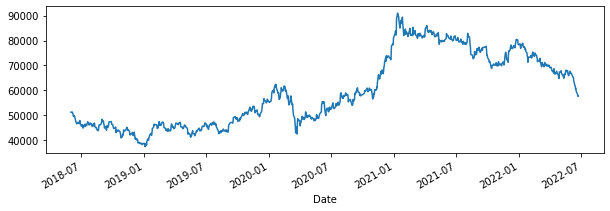

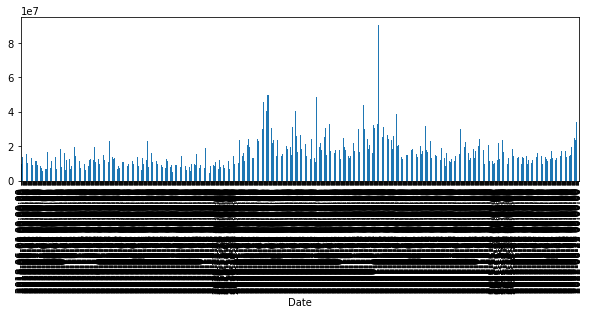

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 3))
df['Close'][-1000:].plot.line()
plt.show()

plt.figure(figsize=(10, 3))
df['Volume'][-1000:].plot.bar()
plt.show()


## 증권 데이터 + LSTM

In [17]:
import FinanceDataReader as fdr

# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
df = fdr.DataReader('005930')

# minmax norm
df_norm = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
print(df_norm.head())

df_norm = df_norm.values[-1507:]
print(df_norm[:10])
print(df_norm.shape)

                Open      High       Low     Close    Volume    Change
Date                                                                  
1998-04-21  0.014164  0.013616  0.013989  0.007260  0.003433       NaN
1998-04-22  0.014330  0.013574  0.014257  0.007127  0.003589  0.446132
1998-04-23  0.014164  0.013213  0.013832  0.007005  0.002355  0.448543
1998-04-24  0.014064  0.013306  0.013844  0.006662  0.004221  0.393565
1998-04-25  0.013931  0.013079  0.013832  0.006662  0.000931  0.478381
[[0.28770764 0.26859504 0.28782123 0.27978575 0.00189567 0.47034978]
 [0.28704319 0.26838843 0.28759777 0.27890042 0.00195654 0.46764796]
 [0.28615725 0.26694215 0.2849162  0.27646577 0.00168651 0.448774  ]
 [0.28372093 0.26466942 0.27955307 0.27026848 0.00272072 0.40237079]
 [0.27751938 0.26095041 0.27865922 0.26916182 0.00259565 0.46450432]
 [0.27663344 0.26136364 0.27910615 0.27270313 0.00203387 0.5229637 ]
 [0.2799557  0.26260331 0.28044693 0.27358846 0.00203078 0.48938549]
 [0.28084164 0.26384

In [18]:
import numpy as np
x_train = np.array([df_norm[i:i+7] for i in range(len(df_norm) - 7)])
print(x_train.shape)
y_train = np.array([df_norm[i+7, 3] for i in range(len(df_norm) - 7)])
print(y_train.shape)

(1500, 7, 6)
(1500,)


In [19]:
x_test, x_train = x_train[-200:], x_train[:-200]
y_test, y_train = y_train[-200:], y_train[:-200]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1300, 7, 6) (1300,)
(200, 7, 6) (200,)


In [39]:
X = tf.keras.layers.Input(shape=(7, 6))
net = tf.keras.layers.LSTM(32)(X)
Y = tf.keras.layers.Dense(1)(net)

model = tf.keras.models.Model(X, Y)
model.compile(loss='mse')

In [40]:
model.fit(x_train, y_train, epochs=60)

Epoch 1/60
41/41 [==============================] - 3s 5ms/step - loss: 0.0048
Epoch 2/60
41/41 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 3/60
41/41 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 4/60
41/41 [==============================] - 0s 5ms/step - loss: 8.5911e-04
Epoch 5/60
41/41 [==============================] - 0s 6ms/step - loss: 8.8917e-04
Epoch 6/60
41/41 [==============================] - 0s 5ms/step - loss: 8.0212e-04
Epoch 7/60
41/41 [==============================] - 0s 6ms/step - loss: 7.5555e-04
Epoch 8/60
41/41 [==============================] - 0s 6ms/step - loss: 7.0701e-04
Epoch 9/60
41/41 [==============================] - 0s 6ms/step - loss: 6.7740e-04
Epoch 10/60
41/41 [==============================] - 0s 6ms/step - loss: 6.2025e-04
Epoch 11/60
41/41 [==============================] - 0s 5ms/step - loss: 6.0415e-04
Epoch 12/60
41/41 [==============================] - 0s 6ms/step - loss: 6.4433e-04
Epoch 13/60
4

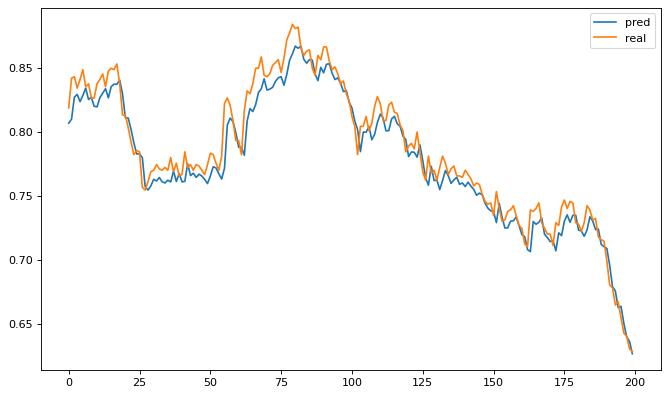

In [41]:
import matplotlib.pyplot as plt

pred = model.predict(x_test)

plt.figure(figsize=(10, 6), dpi=80)
plt.plot(pred)
plt.plot(y_test)
plt.legend(['pred', 'real'])
plt.show()